# Trabajo Final - Gulich

Integrantes:

- Ramos, Pablo Nicolas
- Maina, Marina Soledad

# Objetivo General

Implementar algoritmos de aprendizaje automático supervisado para clasificar características de la coberturt Terrestre en entornos salares.

# Alcance

Este trabajo se centra en la clasificación supervisada de la cobertura terrestre en ambientes salares, utilizando imágenes satelitales multiespectrales (Sentinel-2) y algoritmos de aprendizaje automático como Random Forest y Árboles de decisión. Se utilizan muestras representativas generadas a partir de polígonos etiquetados automáticamente, con el objetivo de generar mapas temáticos que identifiquen clases como “salina”, “agua/humedad”, “vegetación” y “suelo desnudo”. El enfoque permite explorar patrones espectrales y establecer una línea base para el monitoreo de cambios en estos ecosistemas.

# Limitación

La principal limitación del presente estudio radica en que el proceso de etiquetado de las muestras de entrenamiento se realizó mediante algoritmos heurísticos y no fue validado por expertos en teledetección o geología de ambientes salares. Esto puede introducir sesgos en la clasificación y afectar la precisión general del modelo, especialmente en áreas de transición o con coberturas mixtas. Asimismo, la ausencia de validación de campo restringe la robustez de las conclusiones para aplicaciones de monitoreo ambiental o gestión territorial.

# Se usaron imágenes Sentinel L2C

Para observar las imágenes y archivos necesarios para ejecutar el notebook, descargar los archivos del siguiente enlace:

https://drive.google.com/drive/folders/18pogMHfKS9t0q1LtTIu3Pcs-yibxFcgF?usp=sharing

# Etiquetados No Supervisado

El script realiza un etiquetado no supervisado de una imagen satelital multibanda utilizando el algoritmo de clustering K-Means, 
y luego vectoriza los resultados, generando un archivo GeoJSON con polígonos clasificados. 
Es útil para hacer análisis exploratorio o generar muestras cuando no se cuenta con etiquetado experto.


In [13]:
import os
import rasterio
import numpy as np
import geopandas as gpdy
from rasterio.features import shapes
from shapely.geometry import shape
from sklearn.cluster import KMeans

# Ruta donde están los archivos .tiff
folder = "./imagenes/bandas/"  # Asegurate que esta ruta exista y contenga los .tiff

# Lista de bandas disponibles
bandas_disponibles = [
    "B01", "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B09", "B11", "B12"
]

# Cargar imágenes
imagenes = []
for banda in bandas_disponibles:
    # Se cargan distintas bandas espectrales del satélite Sentinel-2. 
    # Cada banda es una matriz 2D de reflectancias por píxel.
    archivo = f"2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_{banda}_(Raw).tiff"
    path = os.path.join(folder, archivo)
    if os.path.exists(path):
        with rasterio.open(path) as src:
            img = src.read(1)
            imagenes.append(img)
            if 'transform' not in locals():
                transform = src.transform
                crs = src.crs
                height, width = img.shape
    else:
        print(f"Archivo no encontrado: {archivo}")

if not imagenes:
    raise RuntimeError("No se encontraron imágenes válidas.")

# Stack de bandas y aplanamiento
stack = np.stack(imagenes, axis=-1)
# El -1 nos permite saber que el total de elementos no debe cambiar
stack_flat = stack.reshape(-1, len(imagenes)) # Cada fila representa un píxel, cada columna representa el valor de una banda en ese píxel
stack_flat = np.nan_to_num(stack_flat) # Si faltan datos (NaN), se reemplazan por 0.

# Clustering con KMeans
# Queremos que nos form 4 grupos o clases (por ejemplo: agua, salina, suelo desnudo, vegetación).
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
etiquetas = kmeans.fit_predict(stack_flat)
etiquetas_img = etiquetas.reshape(height, width)

# Poligonización
# Convierte regiones contiguas con el mismo valor (etiqueta de clase) en polígonos vectoriales.
mask = etiquetas_img != -1
# Se procesan solo los valores que pertenecen a una clase
features = (
    {"geometry": shape(geom), "properties": {"label": int(value)}}
    for geom, value in shapes(etiquetas_img.astype(np.int32), mask=mask, transform=transform)
)

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(features, crs=crs)

# Guardar GeoJSON
salida = "./imagenes/bandas/etiquetado_no_supervisado.geojson"
gdf.to_file(salida, driver="GeoJSON")
print(f"GeoJSON generado correctamente en: {salida}")


GeoJSON generado correctamente en: ./imagenes/bandas/etiquetado_no_supervisado.geojson


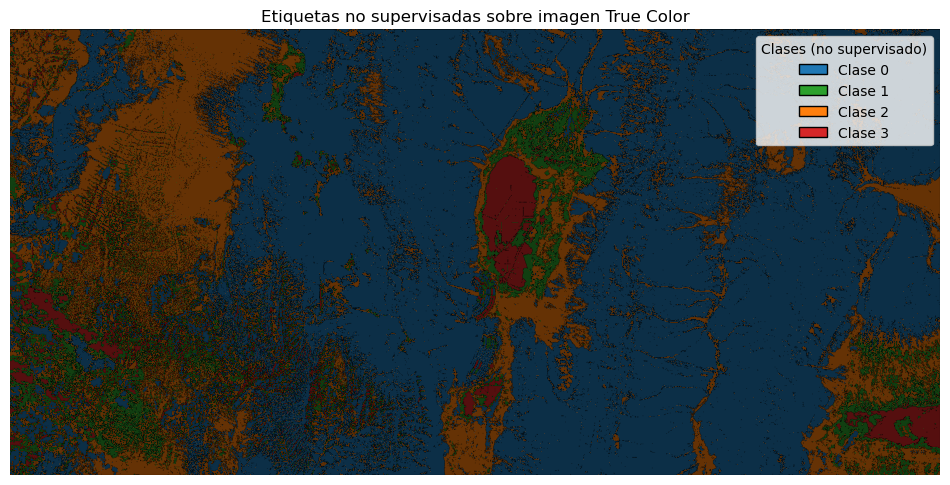

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from rasterio.plot import show
import geopandas as gpd
import rasterio
import os
import numpy as np

# Ruta a la imagen True Color y GeoJSON
folder = "./imagenes/"
geojson_path = "./imagenes/bandas/etiquetado_no_supervisado.geojson"
true_color_path = os.path.join(folder, "2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_True_color.tiff")

# Cargar imagen True Color
with rasterio.open(true_color_path) as src:
    true_color = src.read([1, 2, 3])
    transform = src.transform
    crs = src.crs

# Normalizar imagen para visualización
img_rgb = np.clip(true_color.transpose(1, 2, 0) / 3000.0, 0, 1)

# Cargar los polígonos clasificados
gdf = gpd.read_file(geojson_path)

gdf["area"] = gdf.geometry.area

# Definir colores para cada clase no supervisada
clases = sorted(gdf["label"].unique())
colores = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # 5 colores
color_map = {clase: color for clase, color in zip(clases, colores)}

gdf["color"] = gdf["label"].map(color_map)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 12))

# Imagen de fondo
ax.imshow(img_rgb, extent=(
    transform[2],
    transform[2] + transform[0] * true_color.shape[2],
    transform[5] + transform[4] * true_color.shape[1],
    transform[5]
))

# Polígonos clasificados
gdf.plot(ax=ax, color=gdf["color"], edgecolor="black", linewidth=0.2, alpha=0.4)

# Leyenda con nombres por label
legend_elements = [
    Patch(facecolor=color_map[lbl], edgecolor='black', label=f"Clase {lbl}")
    for lbl in clases
]
ax.legend(handles=legend_elements, title="Clases (no supervisado)", loc="upper right")
ax.set_title("Etiquetas no supervisadas sobre imagen True Color")
ax.axis("off")
plt.show()

# Se genero un geojson con QGIS

In [62]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image, reshape_as_raster
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import mapping
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

In [63]:
geojson_path = "./imagenes/bandas/clases_vf.geojson"  # ruta al archivo de polígonos
folder = "./imagenes/bandas/"  # carpeta con las bandas
output_classified_path = "clasificado.tif"


bandas_usar = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]

In [64]:
raster_bandas = {}

for banda in bandas_usar:
    path = os.path.join(folder, f"2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_{banda}_(Raw).tiff")
    raster_bandas[banda] = rasterio.open(path) # guardamos cada banda Sentinel-2 como un rasterio.DatasetReader

gdf = gpd.read_file(geojson_path)

C:\Users\pablonicolasr\anaconda3\envs\gulich\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 3 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [65]:
data = []

# Se itera sobre cada poligono
for _, row in gdf.iterrows():
    clase = row["clase"]
    geom = [mapping(row["geometry"])]

    valores_banda = {}
    # Extraemos los valores de todas las bandas en el polígono
    for banda, src in raster_bandas.items():
        try:
            imagen, _ = mask(src, geom, crop=True) # recorta el raster al polígono dado
            valores_banda[banda] = imagen[0] # El resultado es una pequeña matriz (raster) con los valores de esa banda dentro del polígono.
        except Exception as e:
            print(f"Error en banda {banda}: {e}")
            valores_banda[banda] = np.full_like(valores_banda["B02"], np.nan)

    shape = valores_banda["B02"].shape # da el alto y ancho del recorte.
    n_pix = shape[0] * shape[1] # Cantidad de pixeles

    for i in range(n_pix): # Itera sobre cada píxel dentro del polígono actual 
        #(ya recortado con mask), donde n_pix es el número total de píxeles en ese parche.
        px = {b: valores_banda[b].flatten()[i] for b in bandas_usar} # valores_banda[b] contiene una imagen (array 2D)
        #para una banda específica recortada por el polígono. flatten(), convierte esa imagen 2D a un vector 1D.
        # Se tomar el valor i del picel en esa banda
        '''
        {
          "B02": 0.13,
          "B03": 0.15,
          ...
          "B12": 0.08
        }
        '''
        px["clase"] = clase # Se agrega etiqueta de clase
        data.append(px)

In [67]:
df = pd.DataFrame(data) # Se usa el diccionario data, donde las claves serán columnas
df.replace([np.inf, -np.inf], np.nan, inplace=True) # Se sustituye valores infinitos (positivos o negativos) por NaN
# Luego eliminamos las filas que tengan al menos un NaN
df.dropna(inplace=True)

In [69]:
X = df[bandas_usar].values
y = df["clase"].values

In [70]:
y

array(['agua_humedad', 'agua_humedad', 'agua_humedad', ...,
       'suelo_desnudo', 'suelo_desnudo', 'suelo_desnudo'],
      shape=(41077,), dtype=object)

In [71]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
ref = raster_bandas["B02"] # Se toma la banda B02 como referencia porque todas las bandas tienen el mismo tamaño, proyección y sistema de coordenadas.
profile = ref.profile # Se extrae el profile (metadatos del raster), ancho, alto y transformación espacial para usar en el archivo de salida.
width = ref.width
height = ref.height
transform = ref.transform

In [73]:
stack = []
'''
Se leen todas las bandas y se apilan en un array tridimensional stack con forma:
(alto, ancho, número_de_bandas)
'''
for banda in bandas_usar:
    img = raster_bandas[banda].read(1)
    stack.append(img)
stack = np.stack(stack, axis=-1)
# Esto crea una "caja de datos multiespectral", donde cada píxel tiene un vector espectral


X_all = stack.reshape(-1, len(bandas_usar)) # reshape(-1, n_bandas) aplana la imagen: convierte cada píxel en una fila.
# De (alto, ancho, bandas) a (total_píxeles, bandas).
# Se genera una máscara booleana mask_valid para ignorar los píxeles con NaN.
mask_valid = ~np.any(np.isnan(X_all), axis=1)
y_pred = np.full(X_all.shape[0], -1, dtype=object)
y_pred[mask_valid] = clf.predict(X_all[mask_valid])

# Se predicen las clases para los píxeles válidos usando el modelo clf
clasificado = y_pred.reshape(height, width)

In [76]:
clases = np.unique(df["clase"]) # array(['agua_humedad', 'salina', 'suelo_desnudo', 'vegetacion'], dtype=object)
class_map = {c: i for i, c in enumerate(clases)}
'''
{
    "agua_humedad": 0,
    "salina": 1,
    "suelo_desnudo": 2,
    "vegetacion": 3
}
'''
inv_map = {v: k for k, v in class_map.items()}
'''
{
    0: "agua_humedad",
    1: "salina",
    2: "suelo_desnudo",
    3: "vegetacion"
}
'''
# Clasifica de text a número segun el diccionario class_map
clasificado_codificado = np.vectorize(class_map.get)(clasificado)

In [77]:
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

In [78]:
with rasterio.open(output_classified_path, 'w', **profile) as dst:
    dst.write(clasificado_codificado.astype(rasterio.uint8), 1)

In [79]:
joblib.dump(class_map, "clase_to_int.pkl")
joblib.dump(inv_map, "int_to_clase.pkl")

print("Clasificación finalizada. Guardado como", output_classified_path)

Clasificación finalizada. Guardado como clasificado.tif


In [81]:
import json

# Guardar mapeo de clase en archivo JSON
with open("./imagenes/bandas/leyenda_clasificado.json", "w") as f:
    json.dump(inv_map, f, indent=4)

print("Se guardó la leyenda como 'leyenda_clasificado.json'")

Se guardó la leyenda como 'leyenda_clasificado.json'


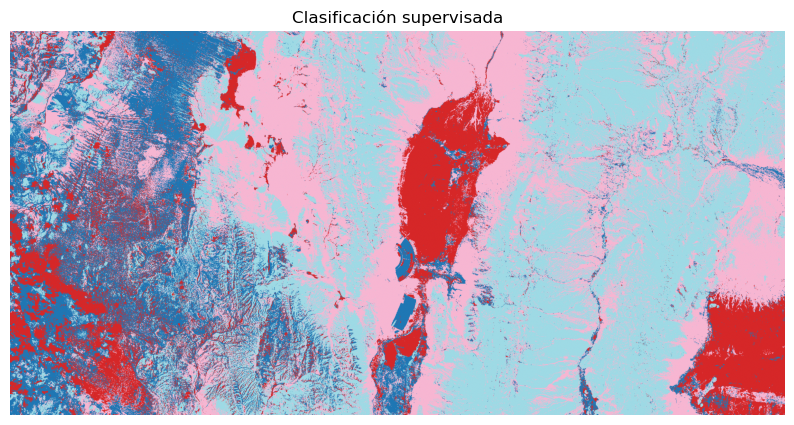

In [57]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("clasificado.tif") as src:
    clasificado = src.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(clasificado, cmap="tab20")
plt.title("Clasificación supervisada")
plt.axis("off")
plt.show()

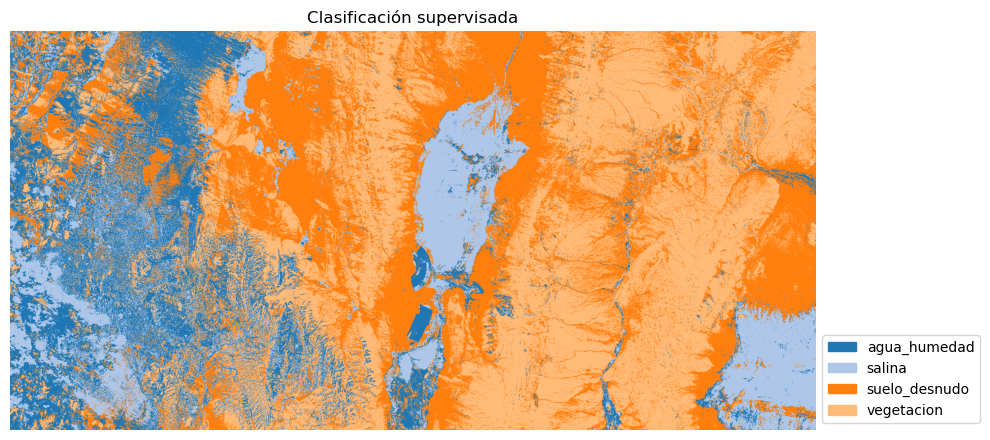

In [86]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Abrir el clasificado
with rasterio.open("clasificado.tif") as src:
    clasificado = src.read(1)

# Cargar leyenda
with open("./imagenes/bandas/leyenda_clasificado.json", "r") as f:
    leyenda = json.load(f)
leyenda = {int(k): v for k, v in leyenda.items()}

# Clases únicas en el raster
clases_unicas = np.unique(clasificado)


base_cmap = plt.get_cmap("tab20")

# Asegurarnos que haya suficientes colores para todas las clases
assert len(clases_unicas) <= base_cmap.N, "Hay más clases que colores disponibles."

# Mapeamos clase -> color de forma manual
colores = [base_cmap(i) for i in range(len(clases_unicas))]
cmap_personalizado = ListedColormap(colores)
norm = BoundaryNorm(clases_unicas.tolist() + [clases_unicas[-1] + 1], cmap_personalizado.N)


plt.figure(figsize=(10, 10))
img = plt.imshow(clasificado, cmap=cmap_personalizado, norm=norm)
plt.title("Clasificación supervisada")
plt.axis("off")

# Crear leyenda con colores reales
patches = [
    mpatches.Patch(color=colores[i], label=leyenda[clase])
    for i, clase in enumerate(clases_unicas)
]
plt.legend(handles=patches, loc="lower left", bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()


# Código para calcular el área por clase (en hectáreas)

In [87]:
import seaborn as sns
from collections import Counter

ruta_tif = "clasificado.tif"  # cambia si está en otra carpeta
ruta_leyenda = "./imagenes/bandas/leyenda_clasificado.json"

with rasterio.open(ruta_tif) as src:
    clasificado = src.read(1)
    perfil = src.profile
    transform = src.transform

with open(ruta_leyenda) as f:
    leyenda = json.load(f)
    leyenda = {int(k): v for k, v in leyenda.items()}

In [88]:
conteo_pixeles = Counter(clasificado.flatten())
conteo_pixeles = {k: v for k, v in conteo_pixeles.items() if k in leyenda}

In [89]:
pixel_area_ha = (perfil["transform"][0] * -perfil["transform"][4]) / 10000  # m² a ha

df_area = pd.DataFrame([
    {
        "clase": clase,
        "nombre_clase": leyenda[clase],
        "pixeles": n_pix,
        "hectareas": n_pix * pixel_area_ha
    }
    for clase, n_pix in conteo_pixeles.items()
])

# === TABLA DE ÁREA POR CLASE ===
print("\nTabla de área por clase:")
print(df_area)


Tabla de área por clase:
   clase   nombre_clase  pixeles      hectareas
0      2  suelo_desnudo   996777  278062.690029
1      0   agua_humedad   518410  144616.578370
2      1         salina   441991  123298.597809
3      3     vegetacion  1142822  318803.663752


C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_5752\327175250.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_area, x="nombre_clase", y="hectareas", palette="tab20")


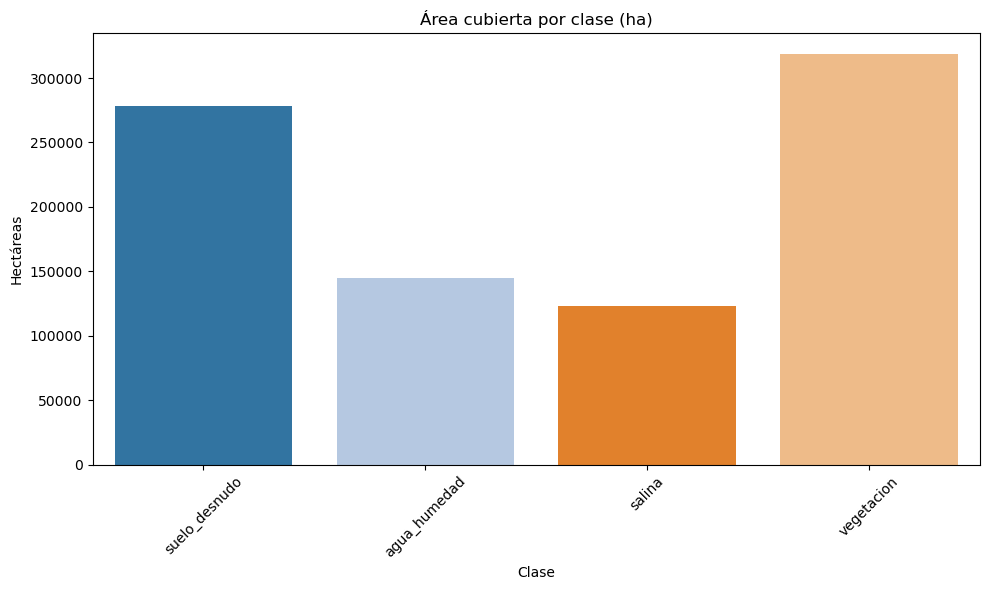

In [90]:
# === GRÁFICO DE ÁREA POR CLASE ===
plt.figure(figsize=(10, 6))
sns.barplot(data=df_area, x="nombre_clase", y="hectareas", palette="tab20")
plt.title("Área cubierta por clase (ha)")
plt.ylabel("Hectáreas")
plt.xlabel("Clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_5752\2060453081.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_area, x="nombre_clase", y="pixeles", palette="tab20")


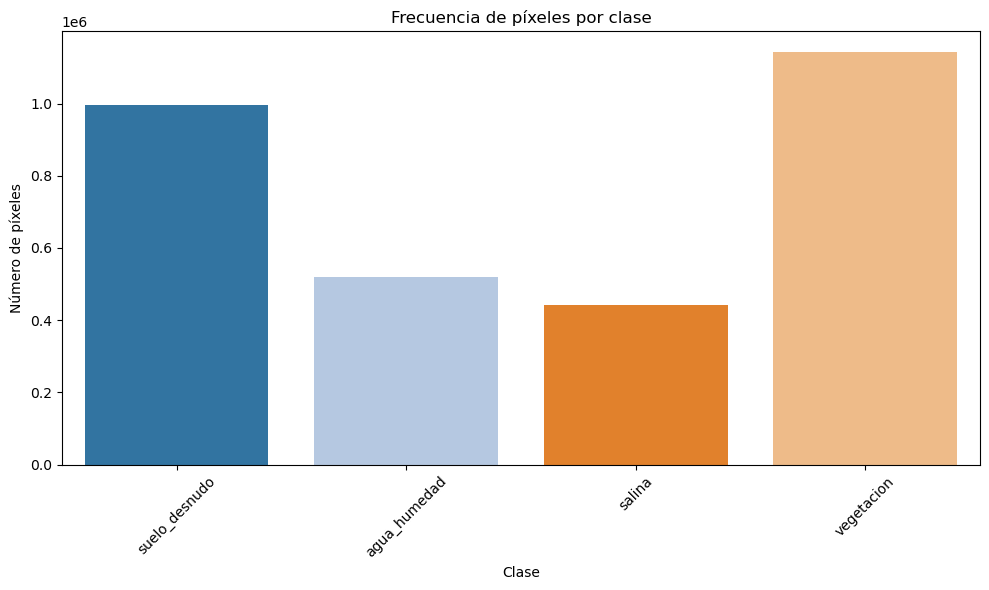

In [93]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_area, x="nombre_clase", y="pixeles", palette="tab20")
plt.title("Frecuencia de píxeles por clase")
plt.ylabel("Número de píxeles")
plt.xlabel("Clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis Exploratorio Completo

In [96]:
import os
import json
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Config
path_bandas = "./imagenes/bandas/"
clasificado_path = "clasificado.tif"
leyenda_path = "./imagenes/bandas/leyenda_clasificado.json"

In [97]:
bandas_usar = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]

with open(leyenda_path) as f:
    leyenda = json.load(f)
leyenda = {int(k): v for k, v in leyenda.items()}

with rasterio.open(clasificado_path) as src:
    clasificado = src.read(1)
    profile = src.profile

In [98]:
raster_bandas = {}
for banda in bandas_usar:
    path = os.path.join(folder_bandas, f"2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_{banda}_(Raw).tiff")
    with rasterio.open(path) as src:
        raster_bandas[banda] = src.read(1)

# Crear DataFrame con todos los píxeles válidos
stack = np.stack([raster_bandas[b] for b in bandas_usar], axis=-1)
flat_stack = stack.reshape(-1, len(bandas_usar))
flat_clas = clasificado.flatten()

mask_valid = flat_clas != 255  # Excluir nodata si corresponde
flat_stack = flat_stack[mask_valid]
flat_clas = flat_clas[mask_valid]

df = pd.DataFrame(flat_stack, columns=bandas_usar)
df["clase"] = flat_clas
df["nombre_clase"] = df["clase"].map(leyenda)

In [104]:
df

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,clase_cod,clase
0,0.0954,0.1337,0.2089,0.2258,0.2353,0.2423,0.2224,0.2449,0.3829,0.3603,2,suelo_desnudo
1,0.1460,0.1825,0.2482,0.2675,0.2761,0.2831,0.2681,0.2781,0.3069,0.2817,2,suelo_desnudo
2,0.1705,0.2063,0.2749,0.2900,0.3015,0.3075,0.3084,0.3035,0.3260,0.2950,0,agua_humedad
3,0.1489,0.1863,0.2573,0.2754,0.2853,0.2892,0.2921,0.2872,0.3230,0.2981,2,suelo_desnudo
4,0.1671,0.2001,0.2643,0.2780,0.2858,0.2895,0.2855,0.2898,0.2809,0.2621,1,salina
...,...,...,...,...,...,...,...,...,...,...,...,...
3099995,0.2036,0.2495,0.3248,0.3484,0.3645,0.3715,0.3789,0.3699,0.3786,0.3097,1,salina
3099996,0.1852,0.2327,0.3008,0.3212,0.3321,0.3408,0.3432,0.3392,0.3626,0.3134,2,suelo_desnudo
3099997,0.1810,0.2265,0.2890,0.3101,0.3294,0.3337,0.3314,0.3357,0.3584,0.3132,1,salina
3099998,0.1895,0.2306,0.2972,0.3223,0.3355,0.3472,0.3484,0.3443,0.3566,0.2960,1,salina


In [105]:
df.to_csv("./imagenes/bandas/datos_exploracion.csv", index=False)

# Análisis exploratorio completo

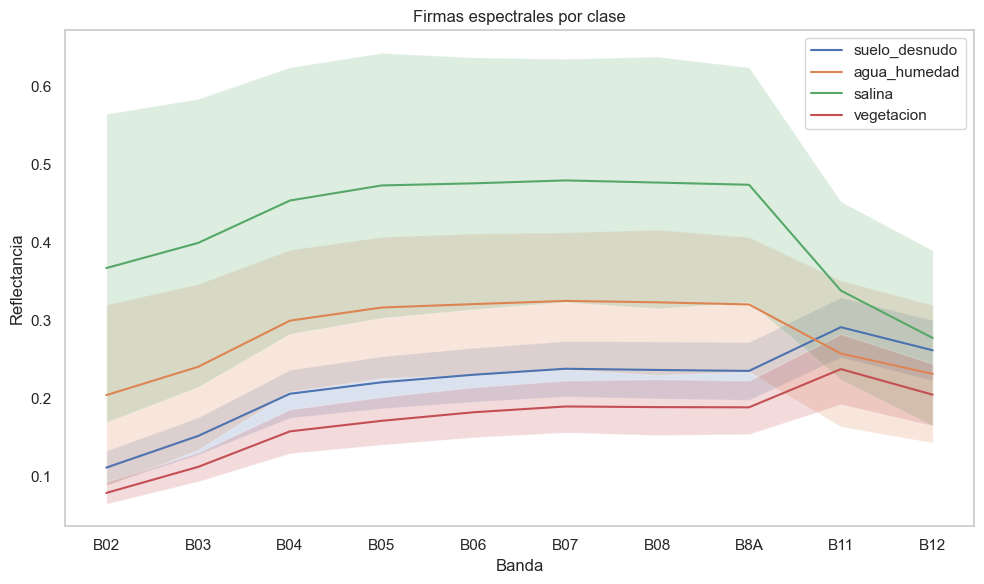

In [111]:
# Firmas espectrales (promedio y desvío)
plt.figure(figsize=(10, 6))
for clase in df["clase"].unique():
    mean = df[df["clase"] == clase][bandas_usar].mean()
    std = df[df["clase"] == clase][bandas_usar].std()
    plt.plot(bandas_usar, mean, label=clase)
    plt.fill_between(bandas_usar, mean - std, mean + std, alpha=0.2)
plt.title("Firmas espectrales por clase")
plt.ylabel("Reflectancia")
plt.xlabel("Banda")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  # Mostramos en pantalla

In [112]:
df["media_reflectancia"] = df[bandas_usar].mean(axis=1)

C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_5752\17635496.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="clase", y="media_reflectancia", palette="Set3")


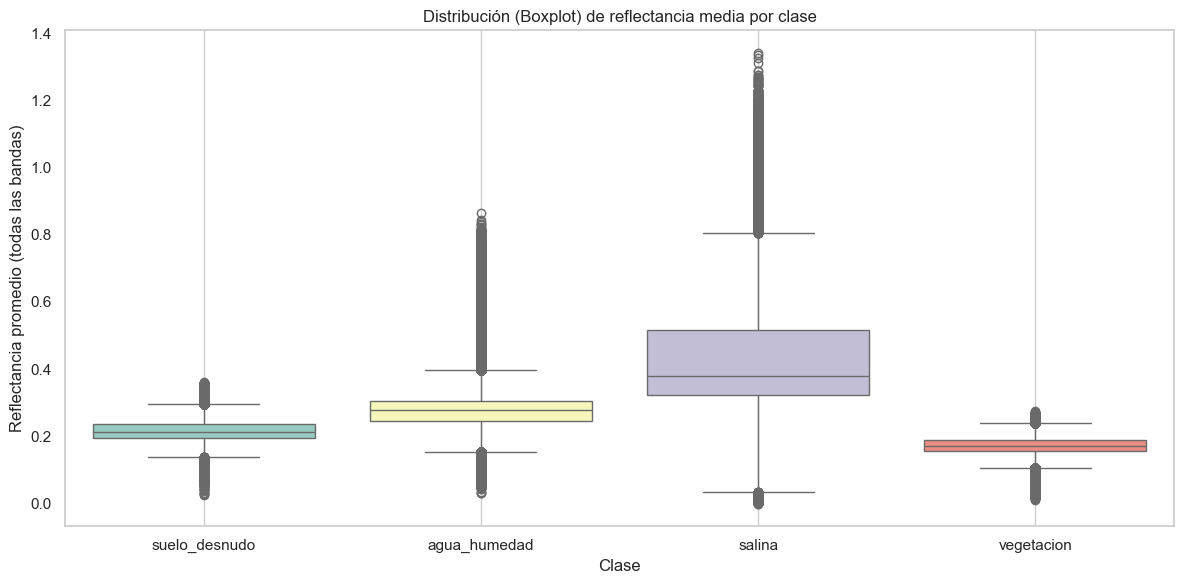

In [113]:
# === Boxplot por clase ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="clase", y="media_reflectancia", palette="Set3")
plt.title("Distribución (Boxplot) de reflectancia media por clase")
plt.ylabel("Reflectancia promedio (todas las bandas)")
plt.xlabel("Clase")
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_5752\596482303.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="clase", y="media_reflectancia", palette="Set2", cut=0)


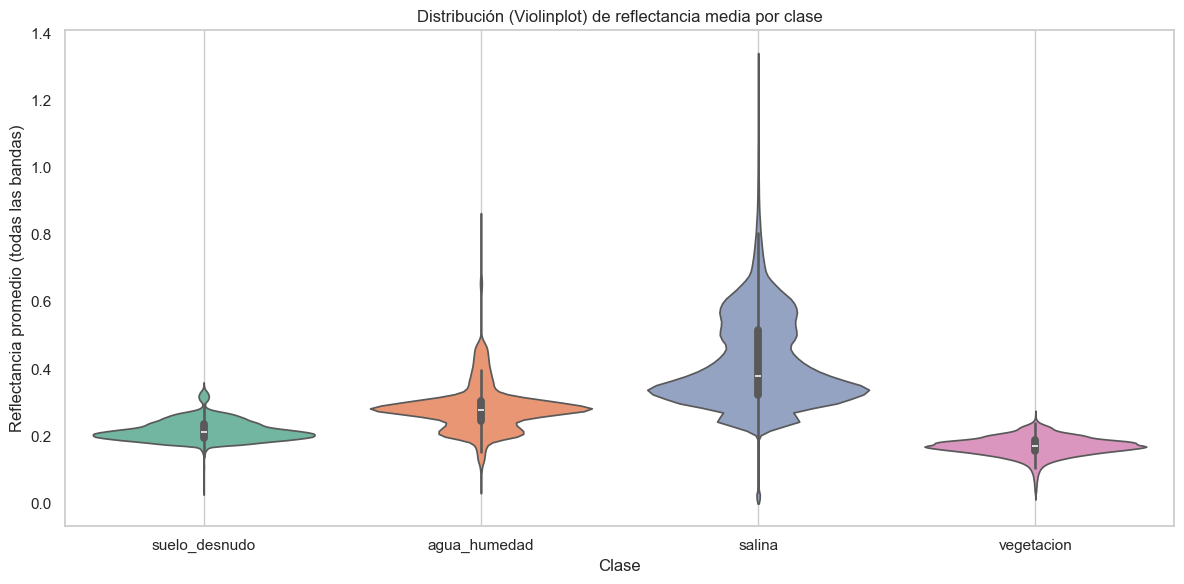

In [115]:
# === Violinplot por clase ===
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="clase", y="media_reflectancia", palette="Set2", cut=0)
plt.title("Distribución (Violinplot) de reflectancia media por clase")
plt.ylabel("Reflectancia promedio (todas las bandas)")
plt.xlabel("Clase")
plt.grid()
plt.tight_layout()
plt.show()

# Aplicación de Técnicas de ML

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import joblib
import time

In [117]:
clasificado_path = "clasificado.tif"
leyenda_path = "./imagenes/bandas/leyenda_clasificado.json"
folder = "./imagenes/bandas/"
bandas_usar = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]


with open(leyenda_path) as f:
    int_to_clase = json.load(f)
clase_to_int = {v: int(k) for k, v in int_to_clase.items()}


with rasterio.open(clasificado_path) as src:
    clasificado = src.read(1)
    height, width = clasificado.shape

In [118]:
band_stack = []
for banda in bandas_usar:
    with rasterio.open(f"{folder}2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_{banda}_(Raw).tiff") as bsrc:
        band_stack.append(bsrc.read(1))
stack = np.stack(band_stack, axis=-1)

In [119]:
# FILTRAR PÍXELES VÁLIDOS
mask = (clasificado >= 0) & (clasificado != 255)
X = stack[mask]
y = clasificado[mask]

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [123]:
# === RANDOM FOREST ===
print("\nEntrenando Random Forest...")
start_rf = time.time()
rf = RandomForestClassifier(random_state=42)
params_rf = {
    "n_estimators": [100],           # Número de árboles
    "max_depth": [10, None],         # Profundidad del árbol
    "min_samples_split": [2, 5],     # Mínimo de muestras para dividir
    "min_samples_leaf": [1],      # Mínimo de muestras en una hoja
}
grid_rf = GridSearchCV(
    rf, params_rf, cv=5, scoring="accuracy", n_jobs=-1, verbose=1,
    return_train_score=True
)
grid_rf.fit(X_train, y_train)
end_rf = time.time()


Entrenando Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [125]:
# === DECISION TREE ===
print("\nEntrenando Decision Tree...")
start_dt = time.time()
dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    "max_depth": [5, 10],
    "min_samples_split": [10],
    "min_samples_leaf": [4],
    "criterion": ["gini", "entropy"]
}
grid_dt = GridSearchCV(
    dt, params_dt, cv=5, scoring="accuracy", n_jobs=-1, verbose=1,
    return_train_score=True
)
grid_dt.fit(X_train, y_train)
end_dt = time.time()


Entrenando Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [126]:
def evaluar_modelo(model, nombre):
    print(f"\n {nombre}")
    print("Mejor score de validación:", model.best_score_)
    print("Mejores hiperparámetros:", model.best_params_)

    y_pred = model.predict(X_test)
    print("\n Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=list(int_to_clase.values())))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(int_to_clase.values()),
                yticklabels=list(int_to_clase.values()))
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel("Predicha")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # Guardar matriz de confusión
    pd.DataFrame(cm, index=list(int_to_clase.values()), columns=list(int_to_clase.values()))\
        .to_csv(f"./imagenes/bandas/confusion_matrix_{nombre.lower().replace(' ', '_')}.csv")


 Random Forest
Mejor score de validación: 0.9839350806451612
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Reporte de clasificación:
               precision    recall  f1-score   support

 agua_humedad       0.98      0.98      0.98    103682
       salina       0.98      0.98      0.98     88398
suelo_desnudo       0.98      0.98      0.98    199356
   vegetacion       0.99      0.99      0.99    228564

     accuracy                           0.98    620000
    macro avg       0.98      0.98      0.98    620000
 weighted avg       0.98      0.98      0.98    620000



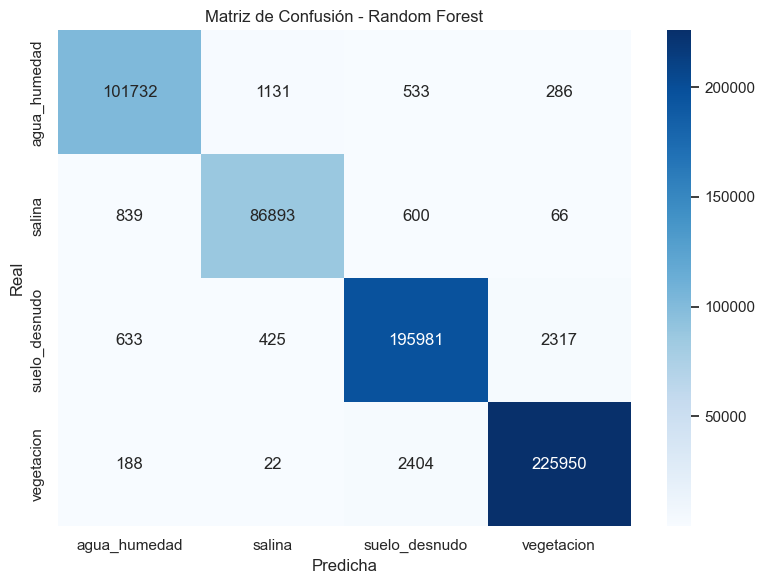


 Decision Tree
Mejor score de validación: 0.9525205645161291
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

 Reporte de clasificación:
               precision    recall  f1-score   support

 agua_humedad       0.96      0.94      0.95    103682
       salina       0.94      0.97      0.95     88398
suelo_desnudo       0.94      0.95      0.94    199356
   vegetacion       0.96      0.96      0.96    228564

     accuracy                           0.95    620000
    macro avg       0.95      0.95      0.95    620000
 weighted avg       0.95      0.95      0.95    620000



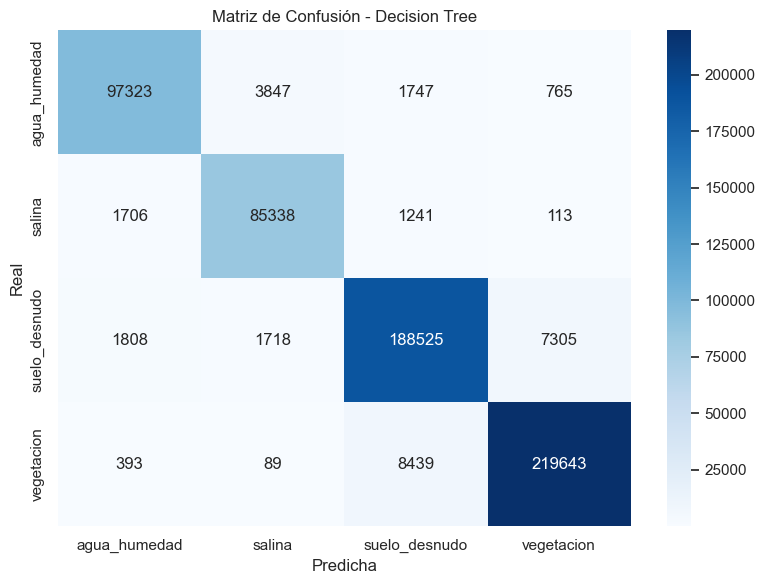

In [127]:
evaluar_modelo(grid_rf, "Random Forest")
evaluar_modelo(grid_dt, "Decision Tree")

In [128]:
# TIEMPOS DE EJECUCIÓN
print(f"\n Tiempo de entrenamiento RF: {end_rf - start_rf:.2f} s")
print(f" Tiempo de entrenamiento DT: {end_dt - start_dt:.2f} s")


 Tiempo de entrenamiento RF: 2821.28 s
 Tiempo de entrenamiento DT: 64.48 s


In [129]:
joblib.dump(grid_rf.best_estimator_, "./imagenes/bandas/models/random_forest_model.pkl")
joblib.dump(grid_dt.best_estimator_, "./imagenes/bandas/models/decision_tree_model.pkl")

['./imagenes/bandas/models/decision_tree_model.pkl']

In [130]:
pd.DataFrame(grid_rf.cv_results_).to_csv("./imagenes/bandas/models/gridsearch_rf_results.csv", index=False)
pd.DataFrame(grid_dt.cv_results_).to_csv("./imagenes/bandas/models/gridsearch_dt_results.csv", index=False)